In [1]:
from utils import *
from sklearn.linear_model import LogisticRegression
from pyglmnet import GLM
%matplotlib inline
%load_ext autoreload
%autoreload 2
vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_xls_file = dat_xls_file.reset_index()
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240

In [2]:
nfish = 1
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
_ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

trial_valid = np.ones(len(swim_starts)).astype('bool')
for n, n_swim in enumerate(swim_starts[:-1]):        
    # examine the swim with short inter-swim-interval
    if swim_starts[n+1] - n_swim < t_sig:    
        trial_valid[n] = False

ncell_ = 6
_ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
# trial_valid = _['trial_valid']
sub_swim = _['sub_swim'][ncell_]
spk_swim = _['spk_swim'][ncell_]*300
spk_list = _['raw_spk_swim'][ncell_]
trial_valid_fit = trial_valid & ((visu[:,:t_pre-10]<=0).sum(axis=-1)==0)

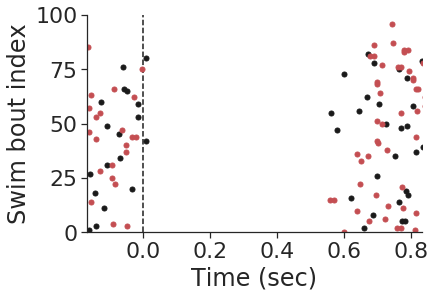

In [3]:
plt_raster(spk_list[(task_period==1) & trial_valid_fit, :], c='k')
plt_raster(spk_list[(task_period==2) & trial_valid_fit, :], c='r')
# plt.title(f'Cell #{n_cell}')
plt.ylabel('Swim bout index')
plt.xlabel('Time (sec)')
plt.xlim([-50/300, 250/300])
# plt.axis('off')
plt.ylim([0, 100])
plt.vlines([0], [0], [320], colors='k', linestyles='--')
sns.despine()

## simple model with visual and voltage

In [74]:
Y_dat = []
X_dat = []
swim_pad = 30
visu_pad = 200
spk_pad = 1
sub_list = sub_swim-sub_swim[:, 70:75].mean(axis=-1, keepdims=True)

for n_, dff_ in enumerate(sub_list):
    if not trial_valid_fit[n_]:
        continue
    spk_ = spk_list[n_]
    visu_ = -visu[n_]
    visu_[visu_<0]=0
    for n_time in range(t_pre, t_pre+240):
        if n_time>200:
            visu_history=visu_[n_time-visu_pad:n_time]
        else:
            visu_history=np.zeros(visu_pad)
            if n_time>t_pre:
                visu_history[-n_time:]=visu_[:n_time]
        Y_dat.append(spk_[n_time])
        X_dat.append(np.r_[1, dff_[n_time-9:n_time],np.sqrt(visu_history)/100])

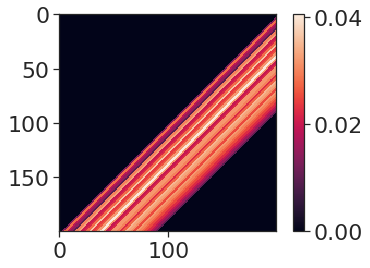

In [91]:
plt.imshow(X_dat[:200, 10:])
plt.colorbar()

In [75]:
Y_dat = np.array(Y_dat)
X_dat = np.array(X_dat)

spike_ind = np.where(Y_dat==1)[0]
no_spike_ind = np.random.choice(np.where(Y_dat==0)[0], size=len(spike_ind)*5)

In [76]:
train_list = np.r_[spike_ind, no_spike_ind]

### Binomial fit of spike with l2 norm

In [115]:
lr = LogisticRegression(penalty='elasticnet',fit_intercept=False, C=1, l1_ratio=0.1, solver='saga').fit(X_dat, Y_dat)
# lr = LogisticRegression(penalty='l2',fit_intercept=True, verbose=True).fit(X_dat, Y_dat)

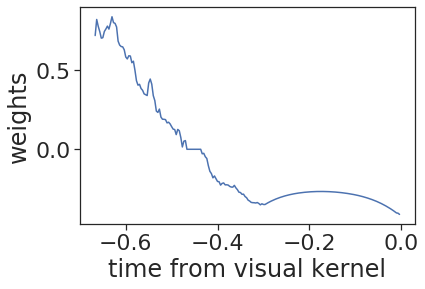

In [116]:
w = lr.coef_
plt.figure()
plt.plot(np.arange(-visu_pad,0)/300, w[0,10:].T)
plt.ylabel('weights')
plt.xlabel('time from visual kernel')
plt.show()

In [117]:
def sigmoid(x):
    return np.where(x>=0, 1/(1 + np.exp(-x)), np.exp(x)/(1 + np.exp(x)))


def log_sig(x):
    return np.where(x>= 0, -np.log(1+np.exp(-x)), x-np.log(1+np.exp(x)))


def loglike(X, y, w):
    q = 2*y-1
    return np.sum(log_sig(q*np.dot(X,w).squeeze()))


def loglike_grad(X, y, w):
    L = sigmoid(np.dot(X,w))
    return np.dot(y - L,X)


def loglike_null(X, y, w):
    q = 2*y-1
    return np.sum(log_sig(q*X*w))


def loglike_hessian(X, y, w):
    L = sigmoid(np.dot(X,w))
    return -np.dot(L*(1-L)*X.T,X)

In [118]:
lr_null = LogisticRegression(fit_intercept=False).fit(X_dat[:,0][:, np.newaxis], Y_dat)

In [119]:
lr_sub = LogisticRegression(fit_intercept=False).fit(X_dat[:,:10], Y_dat)

In [120]:
loglike(X_dat, Y_dat, lr.coef_.T)

-478.7694154263339

In [121]:
loglike_null(X_dat[:,0], Y_dat, lr_null.coef_)

-545.2189059500566

In [122]:
1-loglike(X_dat, Y_dat, lr.coef_.T)/loglike_null(X_dat[:,0], Y_dat, lr_null.coef_)

0.12187671740387085

In [123]:
1-loglike(X_dat[:, :10], Y_dat, lr_sub.coef_.T)/loglike_null(X_dat[:,0], Y_dat, lr_null.coef_)

0.03724304758894337

In [124]:
lr_sub.coef_

array([[-6.59377009,  1.44308704,  1.47079636,  1.51835631,  1.52481805,
         1.53232479,  1.49905832,  1.47490508,  1.45513695,  1.41263372]])